## ARIMA(p,d,q)

General process of building ARIMA model


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.api as smt 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

In [6]:
# read data
file ="../Data/BTCUSD-all.csv"
df=pd.read_csv(file) 


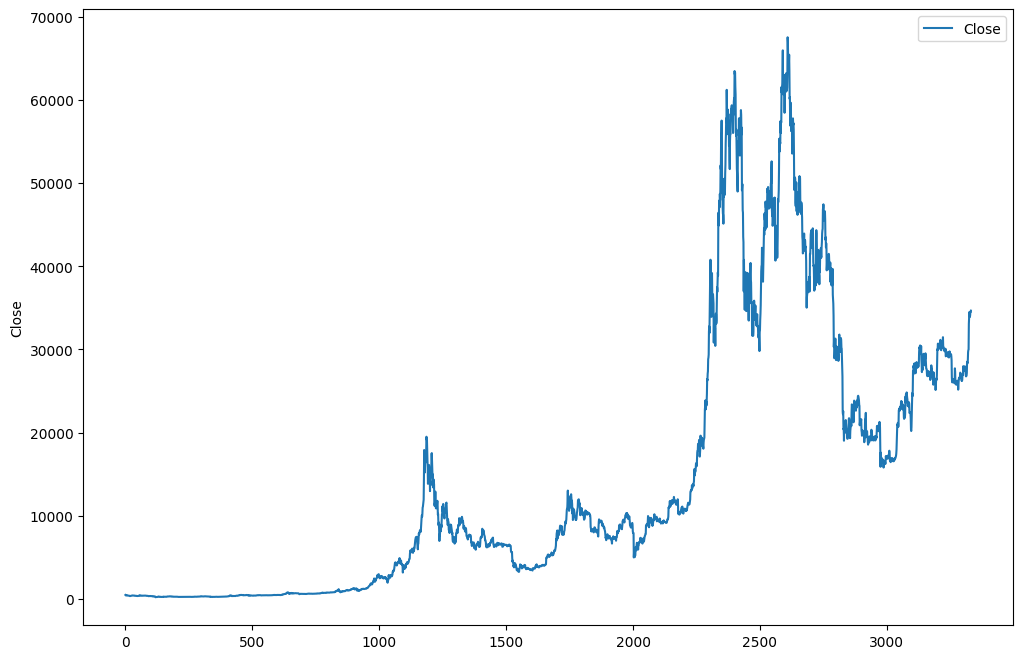

In [7]:
# Visualization of original data
df["Close"].plot(figsize=(12,8), label="Close") 
plt.ylabel("Close")
plt.legend()
plt.show()

### Time series decomposition

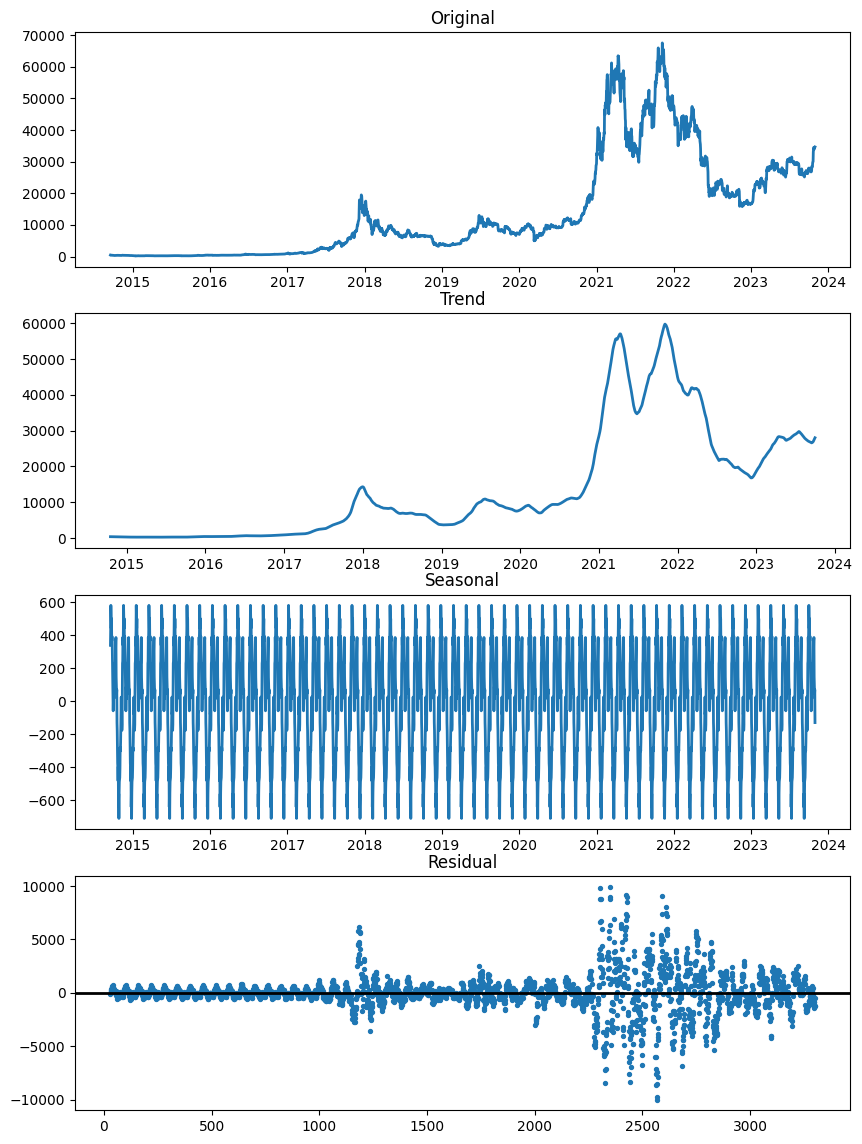

In [8]:
df["Date"] = pd.to_datetime(df["Date"])

# Decompose the 'Close' column #multiplicative or additive
Mmodel='additive'
decomposition = seasonal_decompose(df['Close'], model=Mmodel, period=60)

# Extract the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the components
fig, axes = plt.subplots(4, 1, figsize=(10, 14))  # Set the figure size

# Plot the original series
axes[0].plot(df["Date"],df['Close'], linewidth=2)  # Set the line width (point size)
axes[0].set_title('Original')

# Plot the trend component
axes[1].plot(df["Date"],trend, linewidth=2)
axes[1].set_title('Trend')

# Plot the seasonal component
axes[2].plot(df["Date"],seasonal, linewidth=2)
axes[2].set_title('Seasonal')

# Plot the residual component
axes[3].scatter(residual.index, residual, s=8)
axes[3].axhline(y=0, color='k', linestyle='-', linewidth=2)  # Horizontal line at y=0
axes[3].set_title('Residual')


plt.show()

###  Perform Dickey-Fuller test

In [9]:
def adf_test(timeseries):   
    print("Results of Dickey-Fuller Test\n================================================")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index = [
        "Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Criterical Value (%s)"%key] = value
    print(dfoutput)
    print("================================================")  
  
    if dfoutput[0] < dfoutput[4]:
        print("The data is stationary. (Criterical Value 1%)")  
    elif dfoutput[0] < dfoutput[5]:
        print("The data is stationary. (Criterical Value 5%)") 
    elif dfoutput[0] < dfoutput[6]:
        print("The data is stationary. (Criterical Value 10%)")
    else:
        print("The data is non-stationary, so do differencing!")
adf_test(df['Close'])

Results of Dickey-Fuller Test
Test Statistic                   -1.464049
p-value                           0.551215
#Lags Used                       29.000000
Number of Observations Used    3302.000000
Criterical Value (1%)            -3.432332
Criterical Value (5%)            -2.862416
Criterical Value (10%)           -2.567236
dtype: float64
The data is non-stationary, so do differencing!


Results of Dickey-Fuller Test
Test Statistic                -9.582499e+00
p-value                        2.139838e-16
#Lags Used                     2.800000e+01
Number of Observations Used    3.302000e+03
Criterical Value (1%)         -3.432332e+00
Criterical Value (5%)         -2.862416e+00
Criterical Value (10%)        -2.567236e+00
dtype: float64
The data is stationary. (Criterical Value 1%)


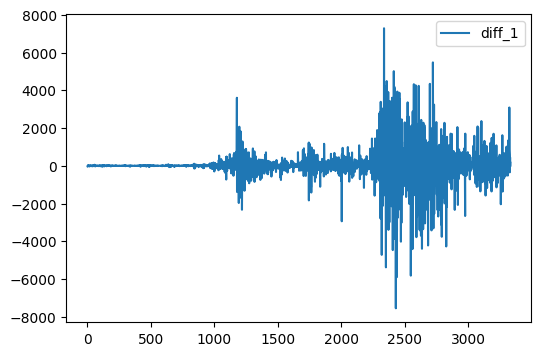

In [10]:
diff_1 = df['Close']-df['Close'].shift(1) 
diff_1 = diff_1.dropna()
diff_1.head()
diff_1.plot(figsize=(6,4), label="diff_1")
plt.legend()

adf_test(diff_1)

In [29]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    results = []    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df


ps = range(0,5, 1)
qs = range(0,5, 1)
d = 1

order_list = list(product(ps, qs))

result_df = optimize_ARIMA(df['Close'], order_list, d)
result_df

C:\Users\nptu\AppData\Local\Temp\ipykernel_5324\1971039175.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for order in tqdm_notebook(order_list):


  0%|          | 0/25 [00:00<?, ?it/s]

c:\Users\nptu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\nptu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\nptu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nptu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as sta

,"(p,q)",AIC
0,"(4, 4)",53772.704084
1,"(2, 4)",53791.618491
2,"(3, 2)",53795.238471
3,"(2, 3)",53795.294052
4,"(3, 3)",53796.946586
5,"(4, 3)",53799.223704
6,"(3, 4)",53802.301397
7,"(0, 0)",53810.298544
8,"(1, 0)",53810.615555
9,"(0, 1)",53810.649864


In [32]:
model = SARIMAX(df['Close'], order=(4, 1, 4), seasonal_order=(0, 0, 0,0))

final_model  = model.fit() 

print(final_model .summary())

c:\Users\nptu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\nptu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3332
Model:               SARIMAX(4, 1, 4)   Log Likelihood              -26877.352
Date:                Tue, 14 Nov 2023   AIC                          53772.704
Time:                        14:17:38   BIC                          53827.703
Sample:                             0   HQIC                         53792.382
                               - 3332                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4894      0.010    -51.074      0.000      -0.508      -0.471
ar.L2          0.7118      0.006    114.658      0.000       0.700       0.724
ar.L3         -0.5240      0.006    -87.094      0.0

c:\Users\nptu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


c:\Users\nptu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\nptu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\nptu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nptu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

This best model is ARIMA(6,1,4) based on argmin RMSE.
RMSE Train:772.6081 Test:4508.1114


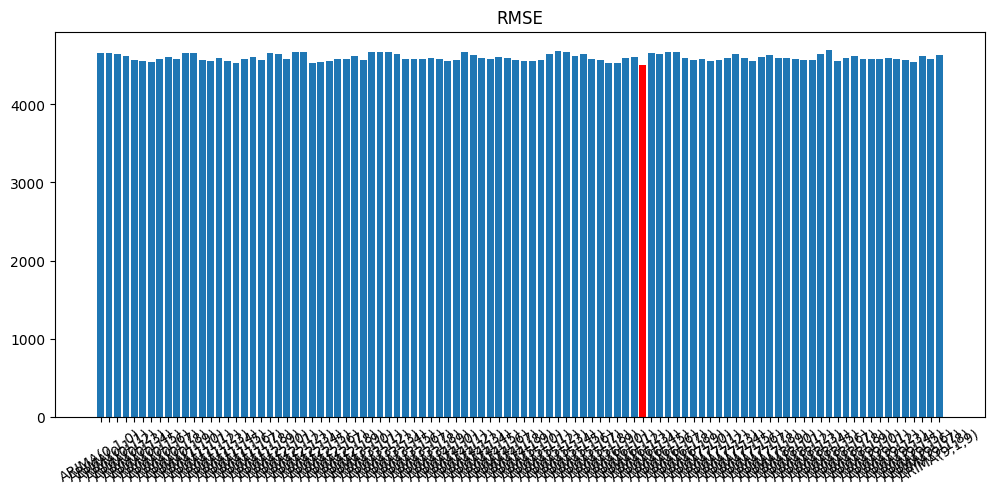

In [62]:
def arima_mse(data, p=4, d=3, q=4,period=7):    
    L =len(data)
    train = data[:(L-period)]
    test = data[-period:]
    train_predict_rmse = []
    test_predict_rmse= []
    model_name = []
    for i in range(p):
        for j in range(1,d):
            for k in range(q):      
                model = SARIMAX(train, order=(i,j,k), seasonal_order=(0, 0, 0,0))
                fitted = model.fit()
                model_name.append(f"ARIMA({i},{j},{k})")

                test_fc= fitted.forecast(period, alpha=0.05)                 
                rmse = mean_squared_error(test,test_fc)**0.5
                test_predict_rmse.append(rmse)
                

                train_fc= fitted.predict(start=0, end=(L-period-1), alpha=0.05)               
                rmse = mean_squared_error(train,train_fc)**0.5
                train_predict_rmse.append(rmse)
                
                # print(f"ARIMA({i},{j},{k})：RMSE={rmse}")
        
    
    min_value =min(test_predict_rmse)
    min_index = test_predict_rmse.index(min_value)
    print("==========================================================================")
    print(f"This best model is {model_name[min_index]} based on argmin RMSE.")
    print(f"RMSE Train:{train_predict_rmse[min_index]:.4f} Test:{test_predict_rmse[min_index]:.4f}")

    plt.figure(figsize=(12,5))
    plt.bar(model_name, test_predict_rmse)
    plt.bar(model_name[min_index], test_predict_rmse[min_index], color = "red")
    plt.xticks(rotation=30)
    # plt.title("RMSE")
    # plt.savefig("ARIMA RMSE")
    plt.show()
arima_mse(df['Close'],10,2,10,14)

In [63]:
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt

# 載入時間序列數據
df = pd.read_csv('../Data/BTCUSD-all.csv')

# 定義要嘗試的ARIMA參數的範圍
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# 定義季節性參數的範圍
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# 初始化最佳模型和最小均方根誤差
best_model = None
best_rmse = float('inf')

# 進行Grid Search
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df['Close'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            # 計算均方根誤差
            rmse = sqrt(mean_squared_error(df['Close'], results.fittedvalues))

            # 更新最佳模型和最小均方根誤差
            if rmse < best_rmse:
                best_rmse = rmse
                best_model = mod

        except:
            continue

# 打印最佳模型的參數
print("Best model parameters:", best_model)

# 擬合最佳模型
final_model = best_model.fit()

# 打印模型診斷信息
print(final_model.summary())


c:\Users\nptu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nptu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nptu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\nptu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

Best model parameters: <statsmodels.tsa.statespace.sarimax.SARIMAX object at 0x000001AA42F97F10>


c:\Users\nptu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                 3332
Model:             SARIMAX(2, 1, 2)x(2, 0, [], 12)   Log Likelihood              -26682.753
Date:                             Tue, 14 Nov 2023   AIC                          53379.506
Time:                                     20:11:03   BIC                          53422.229
Sample:                                          0   HQIC                         53394.798
                                            - 3332                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3608      0.010    139.298      0.000       1.342       1.380
ar.L2         -0.9387      